https://www.kaggle.com/tanlikesmath/intro-aptos-diabetic-retinopathy-eda-starter

In [1]:
PRFX = 'cvTanlikesmath0629'
SEED = 111

# setup

In [2]:
import random 
import numpy as np
import torch
import os

def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

In [3]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
p_o = f'../output/{PRFX}'
Path(p_o).mkdir(exist_ok=True, parents=True)


# prep

In [5]:
p_data = '../input/aptos2019-blindness-detection'

df = pd.read_csv(f'{p_data}/train.csv')

df['path'] = df['id_code'].map(lambda x: f'{p_data}/train_images/{x}.png')
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head()

,diagnosis,path
0,0,../input/aptos2019-blindness-detection/train_i...
1,0,../input/aptos2019-blindness-detection/train_i...
2,2,../input/aptos2019-blindness-detection/train_i...
3,2,../input/aptos2019-blindness-detection/train_i...
4,2,../input/aptos2019-blindness-detection/train_i...


In [6]:
# The images are actually quite big. We will resize to a much smaller size.
bs = 64 #smaller batch size is better for training, but may take longer
sz = 224


In [7]:
tfms = get_transforms(do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,
                      max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='diagnosis') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

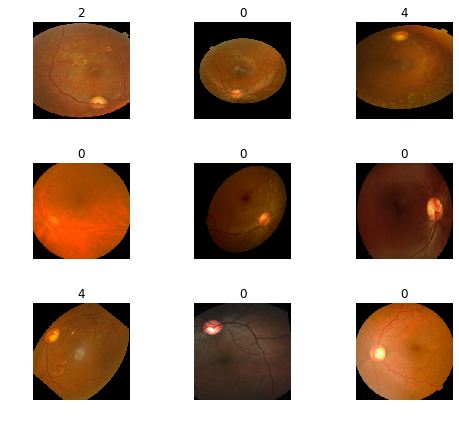

In [8]:
data.show_batch(rows=3, figsize=(7,6))

# Training

In [9]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat,1), y, weights='quadratic'),
                        device='cuda:0')

In [10]:
learn = cnn_learner(data, base_arch=models.resnet50, 
                    metrics = [accuracy,quadratic_kappa], path=p_o)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 1.20E-02
CPU times: user 18min 44s, sys: 3min 29s, total: 22min 14s
Wall time: 17min 8s


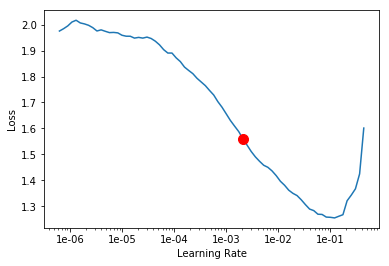

In [11]:
%%time
learn.lr_find()
learn.recorder.plot(suggestion=True)


In [12]:
learn.fit_one_cycle(4,max_lr = 5e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,0.877552,0.758125,0.759563,0.819847,10:53
1,0.707484,0.581973,0.775956,0.825850,10:52
2,0.589697,0.503014,0.818306,0.887702,11:44
3,0.503897,0.471193,0.819672,0.888507,10:50


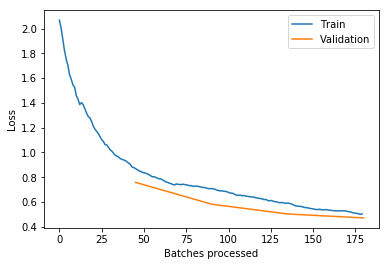

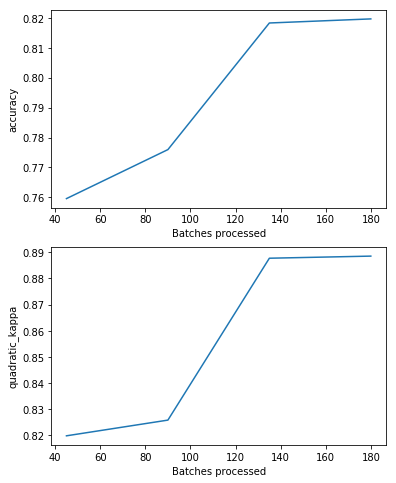

In [13]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-06


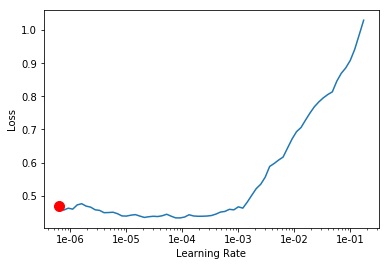

In [14]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [15]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-3))


epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,0.442944,0.471771,0.819672,0.887197,11:06
1,0.444270,0.447581,0.833333,0.895618,10:56
2,0.438730,0.468869,0.814208,0.877876,10:55
3,0.415258,0.433151,0.838798,0.895224,11:17
4,0.391577,0.429648,0.830601,0.882799,11:00
5,0.371841,0.430804,0.833333,0.884532,11:45


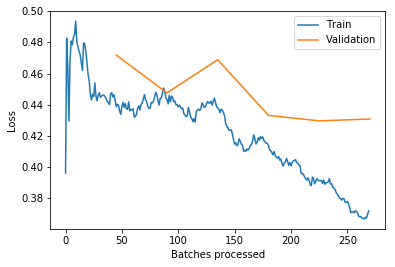

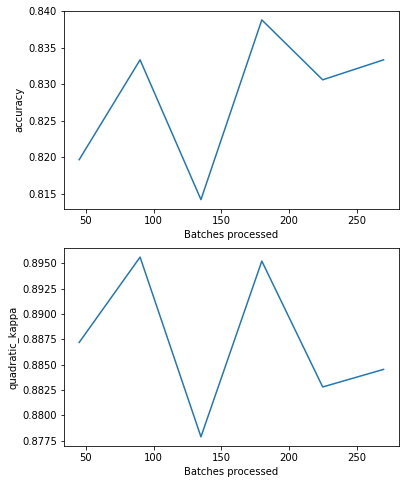

In [16]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [17]:
learn.save('mdl')

# validate

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

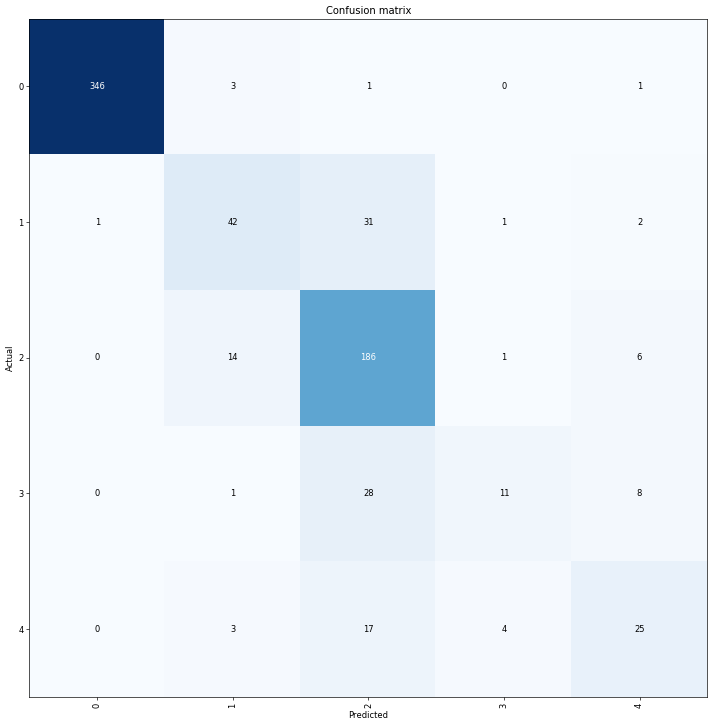

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Optimize the Metric

In [20]:
%%time
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)

CPU times: user 2min 17s, sys: 27.2 s, total: 2min 44s
Wall time: 2min 9s


In [21]:
len(valid_preds), [o.shape for o in valid_preds]

(2, [torch.Size([732, 5]), torch.Size([732])])

In [22]:
import numpy as np
import pandas as pd
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [49]:
valid_preds[0].shape

torch.Size([732, 5])

In [50]:
valid_preds[1].shape

torch.Size([732])

In [52]:
valid_preds[0].argmax(-1).shape

torch.Size([732])

In [54]:
valid_preds[1]==valid_preds[0].argmax(-1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [55]:
valid_preds[0].argmax(dim=-1)

tensor([2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 4, 0, 2, 2,
        2, 2, 2, 2, 0, 4, 0, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 1, 2,
        2, 2, 0, 1, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 4, 0, 0, 2, 0, 2,
        0, 4, 2, 2, 0, 2, 0, 4, 4, 1, 2, 0, 0, 4, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2,
        1, 0, 0, 2, 2, 2, 1, 0, 2, 2, 2, 1, 4, 2, 0, 0, 4, 0, 2, 2, 2, 0, 0, 0,
        2, 2, 2, 2, 0, 1, 0, 0, 0, 2, 2, 1, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1,
        0, 2, 0, 0, 1, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 4, 2, 0, 0, 3, 2, 0, 2,
        3, 0, 2, 4, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0,
        0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0,
        2, 2, 0, 1, 0, 1, 3, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 0, 2, 2, 0, 2, 0, 0,
        3, 0, 1, 0, 1, 2, 2, 1, 1, 0, 4, 0, 2, 0, 2, 0, 0, 0, 0, 4, 0, 1, 0, 0,
        2, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 4, 1, 0, 0, 2, 2, 0, 2, 2, 0,
        1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0,

In [56]:
valid_preds[1]

tensor([2, 2, 0, 2, 0, 2, 0, 0, 1, 3, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 4, 0, 1, 2,
        2, 2, 2, 2, 0, 4, 0, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 4,
        2, 3, 0, 2, 0, 0, 4, 4, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 3, 0, 0, 2, 0, 2,
        0, 4, 4, 2, 0, 2, 0, 4, 4, 1, 3, 0, 0, 4, 0, 2, 0, 0, 2, 2, 0, 3, 2, 1,
        4, 0, 0, 1, 2, 2, 1, 0, 2, 2, 2, 1, 3, 2, 0, 0, 3, 0, 2, 2, 2, 0, 0, 0,
        3, 2, 2, 0, 0, 1, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1,
        0, 4, 0, 0, 1, 0, 1, 0, 2, 0, 2, 2, 0, 0, 0, 0, 4, 3, 0, 0, 3, 2, 0, 2,
        3, 0, 2, 2, 0, 1, 2, 2, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0, 3, 2, 2, 2, 4, 0,
        0, 0, 1, 4, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0,
        2, 2, 0, 1, 0, 1, 4, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 3, 2, 0, 2, 0, 0,
        3, 0, 1, 0, 1, 2, 2, 2, 1, 0, 4, 0, 2, 0, 2, 0, 0, 0, 0, 4, 0, 1, 0, 0,
        2, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 4, 1, 0, 0, 2, 2, 0, 2, 2, 0,
        1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0,

In [57]:
%%time
optR = OptimizedRounder()
optR.fit(valid_preds[0].argmax(dim=-1),valid_preds[1])

coefficients = optR.coefficients()
print(coefficients)

[0.5 1.5 2.5 3.5]
CPU times: user 474 ms, sys: 1.03 ms, total: 475 ms
Wall time: 468 ms


In [25]:
pickle.dump(coefficients, open(f'{p_o}/coefficients.p', 'wb'))

# testing

Restart Kernel Now!!

In [26]:
PRFX = 'cvTanlikesmath0629'
SEED = 111

## setup

In [27]:
import random 
import numpy as np
import torch
import os

def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

In [28]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [30]:
p_o = f'../output/{PRFX}'
Path(p_o).mkdir(exist_ok=True, parents=True)


# prep

In [31]:
p_data = '../input/aptos2019-blindness-detection'

df = pd.read_csv(f'{p_data}/train.csv')

df['path'] = df['id_code'].map(lambda x: f'{p_data}/train_images/{x}.png')
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head()

,diagnosis,path
0,0,../input/aptos2019-blindness-detection/train_i...
1,0,../input/aptos2019-blindness-detection/train_i...
2,2,../input/aptos2019-blindness-detection/train_i...
3,2,../input/aptos2019-blindness-detection/train_i...
4,2,../input/aptos2019-blindness-detection/train_i...


In [32]:
# The images are actually quite big. We will resize to a much smaller size.
bs = 64 #smaller batch size is better for training, but may take longer
sz = 224


In [33]:
tfms = get_transforms(do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,
                      max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='diagnosis') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [34]:
learn = cnn_learner(data, base_arch=models.resnet50, path=p_o).load('mdl')

In [35]:
sample_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [36]:
learn.data.add_test(ImageList.from_df(sample_df,p_data
                                      ,folder='test_images',suffix='.png'))

In [37]:
%%time
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

CPU times: user 2min 35s, sys: 5.74 s, total: 2min 41s
Wall time: 1min 53s


In [46]:
preds

tensor([[1.6220e-02, 8.2162e-01, 8.8199e-02, 4.9997e-03, 6.8961e-02],
        [2.5235e-06, 7.4221e-03, 8.3528e-01, 1.3464e-01, 2.2653e-02],
        [8.1954e-04, 4.4191e-02, 7.7472e-01, 1.1611e-01, 6.4159e-02],
        ...,
        [2.7158e-04, 1.4842e-02, 6.8754e-01, 2.0874e-01, 8.8608e-02],
        [4.0067e-03, 6.3904e-02, 2.5898e-01, 1.8714e-01, 4.8597e-01],
        [3.5259e-01, 1.5193e-02, 1.5951e-02, 1.8232e-01, 4.3395e-01]])

In [47]:
preds.shape

torch.Size([1928, 5])

In [ ]:
preds.

In [39]:
coefficients = pickle.load(open(f'{p_o}/coefficients.p', 'rb'))
optR = OptimizedRounder()
optR.coefficients

<bound method OptimizedRounder.coefficients of <__main__.OptimizedRounder object at 0x7f630a5b30b8>>

In [40]:
test_predictions = optR.predict(preds.argmax(dim=-1), coefficients)

In [41]:
test_predictions

array([1, 2, 2, 2, ..., 2, 2, 4, 4])

In [61]:
np.all(test_predictions==preds.argmax(dim=-1).numpy())

True

## submission

In [42]:
sample_df.diagnosis = test_predictions


In [43]:
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [44]:
sample_df.diagnosis.value_counts()

2    1116
0     386
1     178
3     149
4      99
Name: diagnosis, dtype: int64

In [45]:
sample_df.to_csv('submission.csv',index=False)